In [ ]:
from avcv.all import *
import torch, torch.nn as nn
from dms_drowsiness.video_writer import Board
import onnxruntime
import numpy as np, cv2
from PIL import Image
from ple.all import *

In [ ]:
VIDEO_RAW_DIR_FOOD = '/data/DMS_Behavior_Detection/RawVideos/Action_Eating/'
VIDEO_RAW_DIR_CIGARRET = '/data/DMS_Behavior_Detection/mobile_cigarret_foreignerUS'
VAL_USERS = ['hungng', 'chungtd12', 'thomp4', 'thuyhv5']
PRED_DIR_COCO ='.cache/raw_video_predict_face_food'

In [ ]:
def get_meta_jsons(input):
    """
        Asumming 
    """
    if input.endswith('.mp4'):
        video_path = input
        label_path = input.replace('.mp4', '.json')
    else:
        label_path = input
        video_path = input.replace('.json', '.mp4')

    video_name = get_name(label_path)
    
    pred_json_path = f'{PRED_DIR_COCO}/{video_name}/annotations/pred_mb2_face_food.json'

    assert osp.exists(pred_json_path), f'404 {pred_json_path}'
    assert osp.exists(video_path), f'404 {video_path}'
        
    if not osp.exists(label_path):
        logger.warning(f'404 {label_path=}')
        label_path = None
    
    return dict(
        pred_json_path=pred_json_path,
        label_path = label_path,
        video_path=video_path,
    )


list_json_paths = []
tobe_extract_videos = []

label_paths  = glob(f'{VIDEO_RAW_DIR_FOOD}/**/*.json', recursive=True)
for label_path in label_paths:
    try:
        json_paths = get_meta_jsons(label_path)
        list_json_paths.append(json_paths)
    except Exception as e:
        print(e)
        tobe_extract_videos.append(label_path.replace('.json', '.mp4'))
        pass

label_paths = glob(f'{VIDEO_RAW_DIR_CIGARRET}/*/**/*.json', recursive=True)

for label_path in label_paths:
    try:
        json_paths = get_meta_jsons(label_path)
        list_json_paths.append(json_paths)
    except Exception as e:
        print(e)
        tobe_extract_videos.append(label_path.replace('.json', '.mp4'))
        pass
len(list_json_paths)

109

In [ ]:
%%time
CACHE_DF_PATH = '/tmp/eating_cache_data_df.pkl'
if not osp.exists(CACHE_DF_PATH):
    list_json_paths = load_meta_jsons_with_label()
    
    print('Collecting data from scratch')
    data = multi_thread(collect_data, list(enumerate(list_json_paths)))
    all_data = []
    for _ in data: all_data += _

    df = pd.DataFrame(all_data, columns=['tensor', 'action', 'video_index', 'img_path', 'img_id', 'feat1d'])
    ids = df[df['action'] == 'smocking'].index
    df.loc[ids, 'action'] = 'smoking'

    df['x'] = df.feat1d.apply(convert_f)
    df['y'] = df['action'].apply(get_y)
else:
    print(f'Load data from {CACHE_DF_PATH=}')
    df = mmcv.load(CACHE_DF_PATH)

Load data from CACHE_DF_PATH='/tmp/eating_cache_data_df.pkl'
CPU times: user 90.6 ms, sys: 13.3 ms, total: 104 ms
Wall time: 102 ms


In [ ]:
from scripts.export_onnx import model_wraper, mb2_yolox

IN_CHANNEL_CLS=546
<All keys matched successfully>


In [ ]:
def load_image_tensor(path):
    img = mmcv.imread(path, 0)
    img = mmcv.imrescale(img, INP_SHAPE)
    img = mmcv.impad(img, shape=INP_SHAPE, pad_val=114)
    img = img[None].astype(np.float32)
    return torch.from_numpy(img)

class ImageDataset:
    def __init__(self, img_paths, y=None):
        self.img_paths = img_paths
        self.y = y if y is not None else [0]*len(img_paths)
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, i):
        return load_image_tensor(self.img_paths[i]), self.y[i]
    
# ds = ImageDataset(df.img_path.values)
# dl = td.DataLoader(ds, 2)
# x = next(iter(dl))


In [ ]:
_id2action = dict(enumerate(df['action'].apply(str).unique().tolist()))
action2id = {v:k for k, v in _id2action.items()}
print(action2id)


{'eating': 0, 'none': 1, 'mobile usage': 2, 'smoking': 3}


## Split train/val

In [ ]:
# df.x.values

In [ ]:
from sklearn.model_selection import train_test_split

labels = df.action.unique().tolist()
labels

df_train = df[df.video_index.apply(lambda i: i % 5 != 0)]
df_val = df[df.video_index.apply(lambda i: i % 5 == 0)]
print(f'{len(df_train)=}, {len(df_val)=}')

def df2xy(df):
    return df.img_path.values, np.array(df.y.tolist())

xtrain, ytrain = df2xy(df_train)
xval, yval = df2xy(df_val)

len(df_train)=65748, len(df_val)=18277


## Dataset

In [ ]:
import torch.utils.data as td
class YOutDataset(ImageDataset):
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        return  *res,self.img_paths[idx]

### Get sample data

In [ ]:
ds = YOutDataset(df.img_path, df.y)
dl = td.DataLoader(ds, 2, shuffle=1)
x,y, img_paths = next(iter(dl))

## MyLit

In [ ]:
from scripts.export_onnx import mb2_yolox, SimpleCLS2D

In [ ]:
class ModelWrapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.mb2_yolox = mb2_yolox.requires_grad_(False)
        self.classifier = SimpleCLS2D()
        
    def forward(self, img):
        self.mb2_yolox.eval()
        x = self.mb2_yolox(img)
        x = self.classifier(x)
        return x

In [ ]:
class MyLit(LitModel):
    def forward_loss(self, batch, batch_idx, mode):
        x, y = batch[:2]
        y_onehot = nn.functional.one_hot(y, 4).float()
        probs = self(x)
        loss = self.loss_fn(probs, y_onehot)
        mask = y!=1
        if mask.sum():
            accs = (y_onehot[mask] == (probs[mask]>0.5).float()).float().mean()
            self.log(f"{mode}_acc", accs, prog_bar=True,
                     rank_zero_only=True, on_epoch=True, batch_size=mask.sum())
        self.log(f"{mode}_loss", loss, prog_bar=True,
                 rank_zero_only=True, on_epoch=True)
        return loss
    def training_step(self, b,i): return self.forward_loss(b,i,'training')
    def validation_step(self, b,i): return self.forward_loss(b,i,'val')

## PLData

In [ ]:
from ple.all import *
import torch.utils.data as td
import pytorch_lightning as pl
from fastcore.all import *

class PLData(pl.LightningDataModule):
    def __init__(self, **kwargs):
        super().__init__()
        store_attr(**kwargs)

    def train_dataloader(self):
        dataset = YOutDataset(xtrain, ytrain)
        return td.DataLoader(dataset, self.batch_size, num_workers=self.num_workers, drop_last=True, shuffle=True)

    def val_dataloader(self):
        dataset = YOutDataset(xval, yval)
        return td.DataLoader(dataset, self.batch_size, num_workers=self.num_workers,drop_last=True)
    
pldata = PLData(batch_size=64, num_workers=1)
trainloader = pldata.train_dataloader()
x,y, img_paths = next(iter(trainloader))
print(x.shape, y.shape)

torch.Size([64, 1, 224, 416]) torch.Size([64])


## TriStageExp

In [ ]:
class TriStageExp(BaseExp):

    def __init__(self, exp_name='EXPNAME', 
                 batch_size=64, 
                 num_workers=2, 
                 devices=2,
                 strategy='dp', 
                 **kwargs):
        super().__init__()
        store_attr(**kwargs)

    def get_model(self):
        dl = self.get_data_loader().train_dataloader()
        sched = fn_schedule_cosine_with_warmpup_decay_timm(
            num_epochs=self.max_epochs,
            num_steps_per_epoch=len(dl)//self.devices,
            num_epochs_per_cycle=self.max_epochs//self.num_lr_cycles,
            min_lr=1/100,
            cycle_decay=0.7,
        )
        optim = lambda params:torch.optim.Adam(params)

        return MyLit(self.model, create_optimizer_fn=optim,
                                   create_lr_scheduler_fn=sched, loss_fn=self.loss_fn)

    def get_data_loader(self):
        return PLData(batch_size=self.batch_size, num_workers=self.num_workers)

    def get_trainer(self, **kwargs):
        from ple.trainer import get_trainer
        return get_trainer(self.exp_name, 
                              max_epochs=self.max_epochs, 
                              gpus=self.devices,
                           strategy=self.strategy,
                           **kwargs,

                          )

exp = TriStageExp(exp_name=f'simple_nn/{INP_SHAPE_STR}', batch_size=256, 
                  num_workers=4, devices=1, model=ModelWrapper(), max_epochs=30,
                 loss_fn = BinaryFocalLoss())


In [ ]:
lit_model = exp.get_model()
lit_model.cpu().training_step([x,y],1)

2022-09-26 09:05:53.849 | INFO     | ple.lit_model:fn_schedule_cosine_with_warmpup_decay_timm:66 - num_cycles=3
/home/anhvth8/.conda/envs/py38/lib/python3.8/site-packages/pytorch_lightning/core/module.py:386: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


tensor(0.1639, grad_fn=<MeanBackward0>)

In [ ]:
m = lit_model.model

In [ ]:
m.mb2_yolox.forward??

Signature: m.mb2_yolox.forward(x, targets=None)
Docstring:
Defines the computation performed at every call.

Should be overridden by all subclasses.

.. note::
    Although the recipe for forward pass needs to be defined within
    this function, one should call the :class:`Module` instance afterwards
    instead of this since the former takes care of running the
    registered hooks while the latter silently ignores them.
Source:   
    def forward(self, x, targets=None):
        # fpn output content features of [dark3, dark4, dark5]
        fpn_outs = self.backbone(x)

        if self.training:
            assert targets is not None
            loss, iou_loss, conf_loss, cls_loss, l1_loss, num_fg = self.head(
                fpn_outs, targets, x
            )
            outputs = {
                "total_loss": loss,
                "iou_loss": iou_loss,
                "l1_loss": l1_loss,
                "conf_loss": conf_loss,
                "cls_loss": cls_loss,
                

In [ ]:
# trainer = exp.get_trainer()
# trainer.fit(lit_model, exp.get_data_loader())

# Test

In [ ]:
# lit_model = exp.get_model();

# lit_model.load_from_checkpoint('lightning_logs/simple_nn/00/ckpts/epoch=6-val_acc=0.74.ckpt', model=lit_model.model)
# lit_model = lit_model.cuda().requires_grad_(False).eval()

In [ ]:
session = onnxruntime.InferenceSession('/home/anhvth8/gitprojects/YOLOX/out.onnx')
def predict_onnx(img_path):
    inp = load_image_tensor(img_path).numpy()[None]
    ort_inputs = {session.get_inputs()[0].name: inp.astype(np.float32)}
    probs = session.run(None, ort_inputs)[0]
    return torch.from_numpy(probs).sigmoid().numpy().squeeze().tolist()

res = predict_onnx('/tmp/guiemanhtest224.png')
# res =[0.9980290532112122,0.09712985157966614,2.980232238769531e-07,0.0006951689720153809]
print(res)

[0.7657305002212524, 0.14158980548381805, 0.021903790533542633, 0.0381690114736557]


### Gửi em ảnh test

In [ ]:
# st = torch.load('lightning_logs/simple_nn/224_416/03/ckpts/epoch=0-val_acc=0.86.ckpt')['state_dict']
# new_st = {}
# for k, v in st.items():
#     new_st[k[6:]] = v
# res = model_wraper.classifier.load_state_dict(new_st)
# print(res)
# model_wraper.eval().requires_grad_(False);

In [ ]:
x,y,img_paths = next(iter(pldata.train_dataloader()))

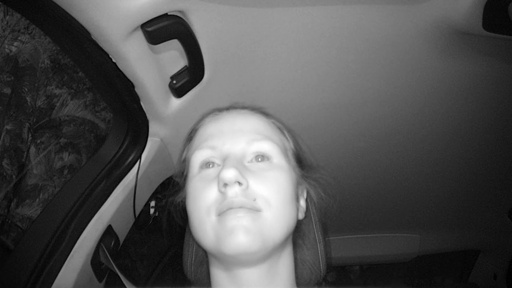

In [ ]:
Image.open(img_paths[0])

In [ ]:
# @torch.inference_mode()
def predict_model_wrapper(img_path, model, device='cuda'):
    model.eval().to(device)
    with torch.no_grad():
        img = load_image_tensor(img_path)[None].to(device)
        probs = lit_model(img).cpu()
    return probs[0].tolist()


In [ ]:
val_json_paths[0]

{'pred_json_path': '/home/anhvth8/gitprojects/YOLOX/.cache/raw_video_predict_face_food/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b_eating_0003/annotations/pred_mb2_face_food.json',
 'label_path': '/data/DMS_Behavior_Detection/RawVideos/Action_Eating/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b_eating_0003.json',
 'video_path': '/data/DMS_Behavior_Detection/RawVideos/Action_Eating/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b_eating_0003.mp4',
 'raw_feat_path': '/home/anhvth8/gitprojects/YOLOX/.cache/raw_video_predict_face_food/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b_ea

'hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b_eating_0003'

In [ ]:
val_ids = df_train.video_index.unique().tolist()
print('Num of val', len(val_ids))
val_json_paths = [list_json_paths[i] for i in val_ids]
# val_json_paths
json_paths = np.random.choice(val_json_paths)
json_paths

Num of val 85


{'pred_json_path': '/home/anhvth8/gitprojects/YOLOX/.cache/raw_video_predict_face_food/evamaria_smoking_0027/annotations/pred_mb2_face_food.json',
 'label_path': '/data/DMS_Behavior_Detection/mobile_cigarret_foreignerUS/training/evamaria/smoking/evamaria_smoking_0027.json',
 'video_path': '/data/DMS_Behavior_Detection/mobile_cigarret_foreignerUS/training/evamaria/smoking/evamaria_smoking_0027.mp4',
 'raw_feat_path': '/home/anhvth8/gitprojects/YOLOX/.cache/raw_video_predict_face_food/evamaria_smoking_0027/annotations/pred_mb2_face_food_2_raw_outputs.pkl'}

In [ ]:
from IPython.display import clear_output

class Visualize:
    def __init__(self, video_or_json_paths):
        if isinstance(video_or_json_paths, dict):
            json_paths = video_or_json_paths
            self.cc = CocoDataset(json_paths['pred_json_path'])
            self.label = Label(mmcv.load(json_paths['label_path']), mmcv.VideoReader(json_paths['video_path']))
            self.input_type = 'coco'
        elif isinstance(video_or_json_paths, str):
            self.video = mmcv.VideoReader(video_or_json_paths)
            self.input_type = 'video'

    def visualize_coco_frame(self, img):
        cc, label = self.cc, self.label
        board = Board(num_lines=6, line_w=500)
        frame = self.cc.visualize(img, score_thr=0.05);
        img_info = cc.gt.imgs[img]
        image = osp.join(cc.img_dir, img_info['file_name'])
        lbl = label.check_action_at_frame_idx(img)
        lbl = lbl[0] if len(lbl) else lbl
        probs = predict_onnx(image)
        for class_idx in range(4):
            action = _id2action[class_idx]
            action = action + ' '*(12-len(action))
            score = probs[class_idx]
            board.set_line_text(class_idx, action, score)
        if lbl is not None:
            board.set_line_text(5, f'Label: {lbl}')

        vis = board.img_concat(frame)
        return vis
    
    def visualize_video_frame(self, img):
        
        board = Board(num_lines=6, line_w=500)
        frame = img = mmcv.imread(img)
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        probs = predict_onnx(img)
        
        for class_idx in range(4):
            action = _id2action[class_idx]
            action = action + ' '*(12-len(action))
            score = probs[class_idx]
            board.set_line_text(class_idx, action, score)

        vis = board.img_concat(frame)
        return vis

    
    def write_video(self):
        if self.input_type == 'coco':
            vis_list = multi_thread(self.visualize_coco_frame, self.cc.img_ids, 1, desc='Get Visualize Imgs')
        else:
            vis_list = []
            pbar = mmcv.ProgressBar(len(self.video))
            for frame_idx, img in enumerate(self.video):
                if frame_idx%3==0:
                    vis_list.append(self.visualize_video_frame(img))
                if frame_idx%10 == 0: pbar.update(10)

        images_to_video(vis_list, 'vis.mp4', output_size=(800, 300))
# Visualize('/tmp/toanbd1_eating_smoking_phoneusage_distraction_drowsiness.avi').write_video()
Visualize(json_paths).write_video()


2022-09-22 07:03:27.034 | INFO     | avcv.process:multi_thread:25 - Get Visualize Imgs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 950/923, 78.3 task/s, elapsed: 12s, ETA:     0s

2022-09-22 07:03:39.468 | INFO     | avcv.process:multi_thread:34 - multi_thread
2022-09-22 07:03:39.472 | INFO     | avcv.utils:images_to_video:267 - Write video, output_size: (800, 300)


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 923/923, 288.1 task/s, elapsed: 3s, ETA:     0s

2022-09-22 07:03:42.678 | INFO     | avcv.utils:images_to_video:277 - -> /home/anhvth8/gitprojects/YOLOX/vis.mp4
